In [1]:
#TODO: Stitching after fixing the error

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange


### **Importing Drive (Dataset-Small Village-Sensefly)**

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.figure(figsize=(20,10)) 


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [88]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(img)
  plt.show()
  


time: 57.8 ms (started: 2021-06-01 12:38:40 +00:00)


In [5]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M,len(best_inliers)




In [6]:

def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):

    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Populate_Images(img, accumulator, H, bw):
  


    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [7]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    #width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Populate_Images(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



In [8]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python===4.4.0.44
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [9]:
import cv2
print(cv2.__version__)

4.1.2


## **Reading images and Extracting the SuperPoint (Self-Supervised Interest Point Detection and Description) Features**

In [10]:
!pip install ipython-autotime

%load_ext autotime


time: 147 µs (started: 2021-06-01 11:20:57 +00:00)


In [11]:
files_all=[]
for file in os.listdir("/content/drive/My Drive/Small_Village"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/Small_Village/'

centre_file = folder_path + files_all[5]
left_files_path_rev = []
right_files_path = []

for file in files_all[4:10]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[9:15]:
  right_files_path.append(folder_path + file)


time: 7.58 ms (started: 2021-06-01 11:20:57 +00:00)


In [12]:
'''
files_all=[]
for file in os.listdir("/content/drive/My Drive/tech_park"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/tech_park/'

centre_file = folder_path + files_all[4+3]
left_files_path_rev = []
right_files_path = []

for file in files_all[:6]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[5:11]:
  right_files_path.append(folder_path + file)
'''

'\nfiles_all=[]\nfor file in os.listdir("/content/drive/My Drive/tech_park"):\n    if file.endswith(".JPG"):\n      files_all.append(file)\n\n\n\n#files_all = os.listdir(\'/content/drive/My Drive/tech_park/\')\nfiles_all.sort()\nfolder_path = \'/content/drive/My Drive/tech_park/\'\n\ncentre_file = folder_path + files_all[4+3]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:6]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[5:11]:\n  right_files_path.append(folder_path + file)\n'

time: 3.1 ms (started: 2021-06-01 11:20:57 +00:00)


In [13]:
'''
files_all = os.listdir('/content/drive/My Drive/small_villages_2/')
files_all.sort()
folder_path = '/content/drive/My Drive/small_villages_2/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:15]:
  right_files_path.append(folder_path + file)
'''

"\nfiles_all = os.listdir('/content/drive/My Drive/small_villages_2/')\nfiles_all.sort()\nfolder_path = '/content/drive/My Drive/small_villages_2/'\n\ncentre_file = folder_path + files_all[7]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:8]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[7:15]:\n  right_files_path.append(folder_path + file)\n"

time: 2.89 ms (started: 2021-06-01 11:20:57 +00:00)


In [14]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1029.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG']
time: 1.02 ms (started: 2021-06-01 11:20:57 +00:00)


In [15]:
print(right_files_path)

['/content/drive/My Drive/Small_Village/IMG_1029.JPG', '/content/drive/My Drive/Small_Village/IMG_1030.JPG', '/content/drive/My Drive/Small_Village/IMG_1031.JPG', '/content/drive/My Drive/Small_Village/IMG_1032.JPG', '/content/drive/My Drive/Small_Village/IMG_1033.JPG', '/content/drive/My Drive/Small_Village/IMG_1034.JPG']
time: 664 µs (started: 2021-06-01 11:20:57 +00:00)


In [63]:
images_left = []
images_right = []


for file in tqdm(left_files_path):
  left_img_sat= cv2.imread(file,0)
  left_img = cv2.resize(left_img_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC)
  #left_img_gray = cv2.cvtColor(left_img,cv2.COLOR_BGR2GRAY)

  images_left.append(left_img_gray.astype(np.float32)/255.)


for file in tqdm(right_files_path):
  right_img_sat= cv2.imread(file,0)
  right_img = cv2.resize(right_img_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC)
  #right_img_gray = cv2.cvtColor(right_img,cv2.COLOR_BGR2GRAY)

  images_right.append(right_img_gray.astype(np.float32)/255.)




time: 1.74 s (started: 2021-06-01 12:21:53 +00:00)


In [17]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.
time: 4.34 s (started: 2021-06-01 11:36:17 +00:00)


In [18]:
!ls

drive  sample_data  SuperPointPretrainedNetwork
time: 114 ms (started: 2021-06-01 11:37:26 +00:00)


In [28]:
!SuperPointPretrainedNetwork/demo_superpoint.py drive/MyDrive/Small_Village_Subset/ --weights_path 'SuperPointPretrainedNetwork/superpoint_v1.pth'

Namespace(H=120, W=160, camid=0, conf_thresh=0.015, cuda=False, display_scale=2, img_glob='*.png', input='drive/MyDrive/Small_Village_Subset/', max_length=5, min_length=2, nms_dist=4, nn_thresh=0.7, no_display=False, show_extra=False, skip=1, waitkey=1, weights_path='SuperPointPretrainedNetwork/superpoint_v1.pth', write=False, write_dir='tracker_outputs/')
[ERROR:0] global /io/opencv/modules/videoio/src/cap.cpp (116) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.1.2) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): drive/MyDrive/Small_Village_Subset/ in function 'icvExtractPattern'


==> Processing Image Directory Input.
==> Loading pre-trained network.
==> Successfully loaded pre-trained network.
: cannot connect to X server 
time: 917 ms (started: 2021-06-01 11:45:37 +00:00)


In [37]:
#Reference: https://github.com/magicleap/SuperPointPretrainedNetwork/blob/master/demo_superpoint.py
import argparse
import glob
import numpy as np
import os
import time

import cv2
import torch


# Jet colormap for visualization.
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])

class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    return semi, desc




  




time: 2.36 s (started: 2021-06-01 12:00:31 +00:00)


In [196]:
class SuperPointFrontend(object):
  """ Wrapper around pytorch net to help with pre and post image processing. """
  def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
               cuda=False):
    self.name = 'SuperPoint'
    self.cuda = cuda
    self.nms_dist = nms_dist
    self.conf_thresh = conf_thresh
    self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
    self.cell = 8 # Size of each output cell. Keep this fixed.
    self.border_remove = 4 # Remove points this close to the border.

    # Load the network in inference mode.
    self.net = SuperPointNet()
    if cuda:
      # Train on GPU, deploy on GPU.
      self.net.load_state_dict(torch.load(weights_path))
      self.net = self.net.cuda()
    else:
      # Train on GPU, deploy on CPU.
      self.net.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
    self.net.eval()

  def nms_fast(self, in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T
  
    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.
  
    Grid Value Legend:
    -1 : Kept.
     0 : Empty or suppressed.
     1 : To be processed (converted to either kept or supressed).
  
    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.
  
    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds

time: 48.3 ms (started: 2021-06-01 15:40:12 +00:00)


In [198]:
def run(self, img):
    """ Process a numpy image to extract points and descriptors.
    Input
      img - HxW numpy float32 input image in range [0,1].
    Output
      corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      desc - 256xN numpy array of corresponding unit normalized descriptors.
      heatmap - HxW numpy heatmap in range [0,1] of point confidences.
      """
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    H, W = img.shape[0], img.shape[1]
    inp = img.copy()
    inp = (inp.reshape(1, H, W))
    inp = torch.from_numpy(inp)
    inp = torch.autograd.Variable(inp).view(1, 1, H, W)
    if self.cuda:
      inp = inp.cuda()
    # Forward pass of network.
    outs = self.net.forward(inp)
    semi, coarse_desc = outs[0], outs[1]
    # Convert pytorch -> numpy.
    semi = semi.data.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / self.cell)
    Wc = int(W / self.cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell])
    xs, ys = np.where(heatmap >= self.conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = self.border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    # --- Process descriptor.
    D = coarse_desc.shape[1]
    if pts.shape[1] == 0:
      desc = np.zeros((D, 0))
    else:
      # Interpolate into descriptor map using 2D point locations.
      samp_pts = torch.from_numpy(pts[:2, :].copy())
      samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
      samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
      samp_pts = samp_pts.transpose(0, 1).contiguous()
      samp_pts = samp_pts.view(1, 1, -1, 2)
      samp_pts = samp_pts.float()
      if self.cuda:
        samp_pts = samp_pts.cuda()
      desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
      desc = desc.data.cpu().numpy().reshape(D, -1)
      desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc, heatmap


def nn_match_two_way(self, desc1, desc2, nn_thresh):
    """
    Performs two-way nearest neighbor matching of two sets of descriptors, such
    that the NN match from descriptor A->B must equal the NN match from B->A.
    Inputs:
      desc1 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      desc2 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      nn_thresh - Optional descriptor distance below which is a good match.
    Returns:
      matches - 3xL numpy array, of L matches, where L <= N and each column i is
                a match of two descriptors, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, match_score]^T
    """
    assert desc1.shape[0] == desc2.shape[0]
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
      return np.zeros((3, 0))
    if nn_thresh < 0.0:
      raise ValueError('\'nn_thresh\' should be non-negative')
    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2-2*np.clip(dmat, -1, 1))
    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    # Threshold the NN matches.
    keep = scores < nn_thresh
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    # Get the surviving point indices.
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    # Populate the final 3xN match data structure.
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    return matches



#matches = self.nn_match_two_way(self.last_desc, desc, self.nn_thresh)

time: 123 ms (started: 2021-06-01 15:40:34 +00:00)


In [42]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

time: 1.1 ms (started: 2021-06-01 12:04:08 +00:00)


In [64]:
print('==> Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 4,conf_thresh = 0.015,nn_thresh=0.7,
                        cuda=cuda)
print('==> Successfully loaded pre-trained network.')

==> Loading pre-trained network.
==> Successfully loaded pre-trained network.
time: 21.2 ms (started: 2021-06-01 12:22:16 +00:00)


In [193]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[1], pt[0], size) for pt in pts]

time: 1.38 ms (started: 2021-06-01 15:32:53 +00:00)


## **Extracting the Keypoints and Descriptors**

In [194]:

keypoints_all_left = []
descriptors_all_left = []
points_all_left=[]

keypoints_all_right = []
descriptors_all_right = []
points_all_right=[]

for lfpth in tqdm(images_left):
  kpt, descrip, heatmap = fe.run(lfpth)


  #kpt_f = kpt[:,np.where([kpt[2,:]>0])[0]]
  #descrip_f = descrip[:,np.where([kpt[2,:]>0])[0]]

  keypoints_all_left.append(to_kpts(kpt.reshape(kpt.shape[1],kpt.shape[0])))
  descriptors_all_left.append(descrip.reshape(descrip.shape[1],descrip.shape[0]))
  points_all_left.append(np.asarray([[p[1], p[0]] for p in kpt.reshape(kpt.shape[1],kpt.shape[0])]))

for rfpth in tqdm(images_right):
  kpt, descrip, _ = fe.run(rfpth)
  #kpt_f = kpt[:,np.where([kpt[2,:]>0])[0]]
  #descrip_f = descrip[:,np.where([kpt[2,:]>0])[0]]
  keypoints_all_right.append(to_kpts(kpt.reshape(kpt.shape[1],kpt.shape[0])))
  descriptors_all_right.append(descrip.reshape(descrip.shape[1],descrip.shape[0]))
  points_all_right.append(np.asarray([[p[1], p[0]] for p in kpt.reshape(kpt.shape[1],kpt.shape[0])]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "



time: 7.89 s (started: 2021-06-01 15:33:02 +00:00)


In [186]:
print(kpt)

[[1.64600000e+03 2.52700000e+03 3.08200000e+03 ... 1.30500000e+03
  1.91600000e+03 1.97100000e+03]
 [1.29300000e+03 1.80000000e+03 5.59000000e+02 ... 2.82000000e+02
  2.67000000e+02 1.81100000e+03]
 [7.23046541e-01 7.03304470e-01 7.01154470e-01 ... 1.50092300e-02
  1.50043471e-02 1.50034660e-02]]
time: 1.6 ms (started: 2021-06-01 15:26:24 +00:00)


In [74]:
print(len(images_left))

6
time: 818 µs (started: 2021-06-01 12:28:04 +00:00)


In [75]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1029.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG']
time: 776 µs (started: 2021-06-01 12:28:08 +00:00)


In [76]:
print(len(right_files_path))

6
time: 798 µs (started: 2021-06-01 12:28:10 +00:00)


## **Image Matching (Robust) through RANSAC and Homography Matrix computation**

In [ ]:
#!pip install numba  # pip

In [183]:

def get_Hmatrix(imgs,keypts,pts,descripts,disp=True):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  ransac_thresh = 6
  #bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)



  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])

  #matches_lf1_lf = bf.match(lff1, lff)

  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print(len(matches_lf1_lf))

  #matches_4 = matches_lf1_lf

  
  '''
  matches_4 = []
  ratio = 0
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches",len(matches_4))

  if len(matches_4)<20:
    matches_4 = []
    ratio = 0.93
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches",len(matches_4))
    ransac_thresh = 9
  
  '''

  matches_4=[]
  for m in matches_lf1_lf:
    matches_4.append(m[0])


  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  Hn = H
  #Robustly estimate Homography 1 using RANSAC
  #Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=ransac_thresh)

  global inlier_matchset   

  if disp==True:
    dispimg1=cv2.drawMatches(np.uint8(imgs[0]*255), keypts[0], np.uint8(imgs[1]*255), keypts[1], matches_4, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')

  return Hn/Hn[2,2]






time: 33.8 ms (started: 2021-06-01 15:24:49 +00:00)


In [82]:
print(len(images_left))

6
time: 854 µs (started: 2021-06-01 12:30:18 +00:00)


In [83]:
print(len(images_right))

6
time: 843 µs (started: 2021-06-01 12:30:27 +00:00)


6716


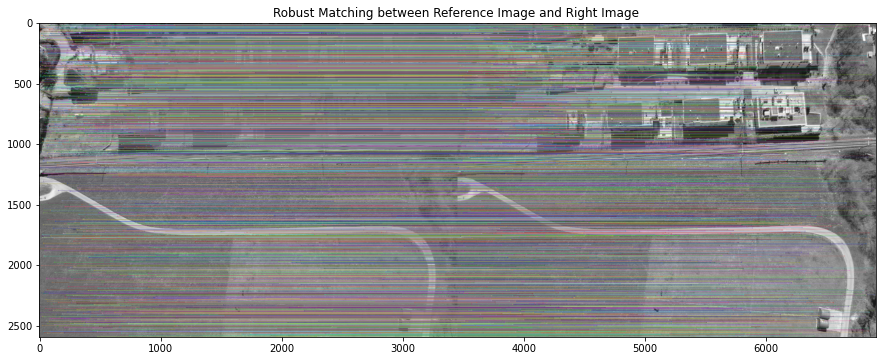

6716


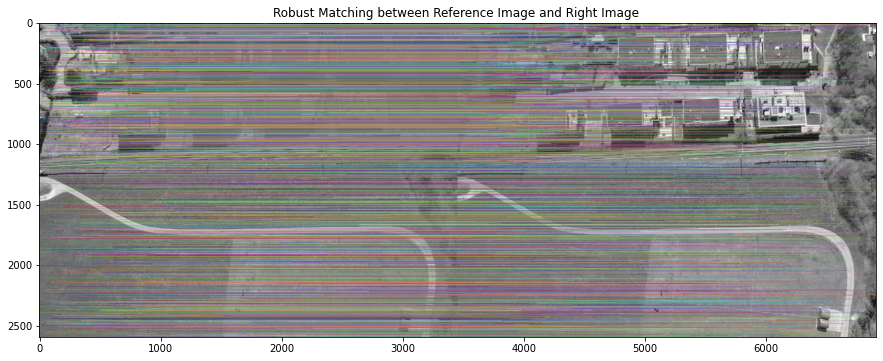

6716


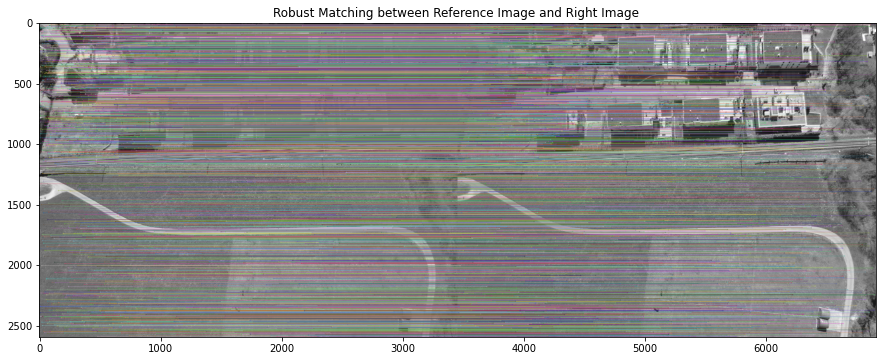

6716


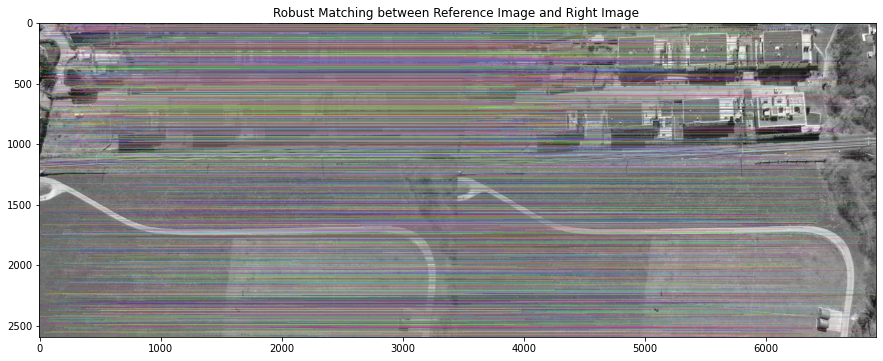

6716


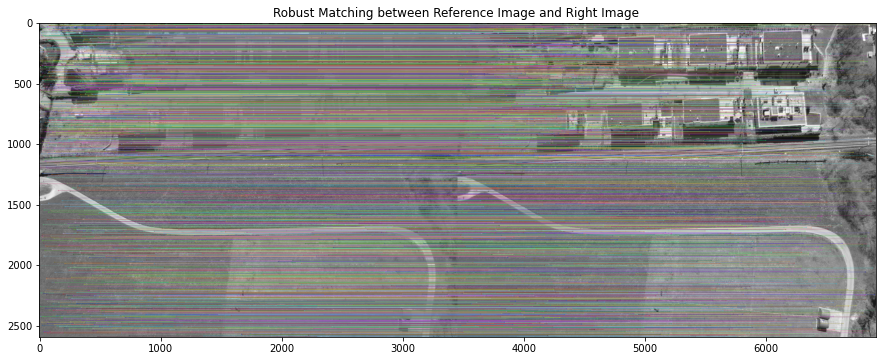

11847


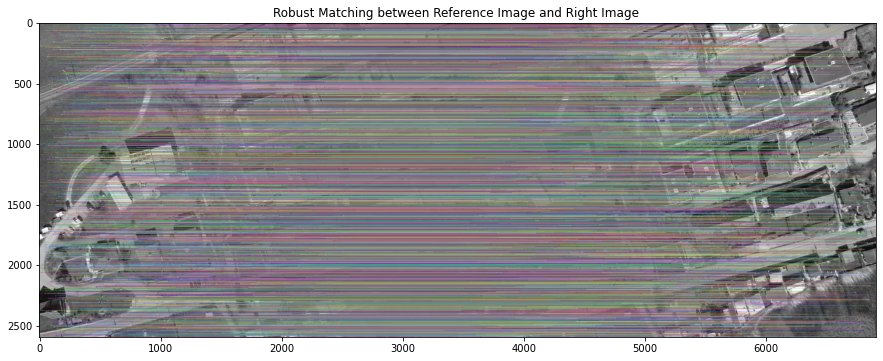

11847


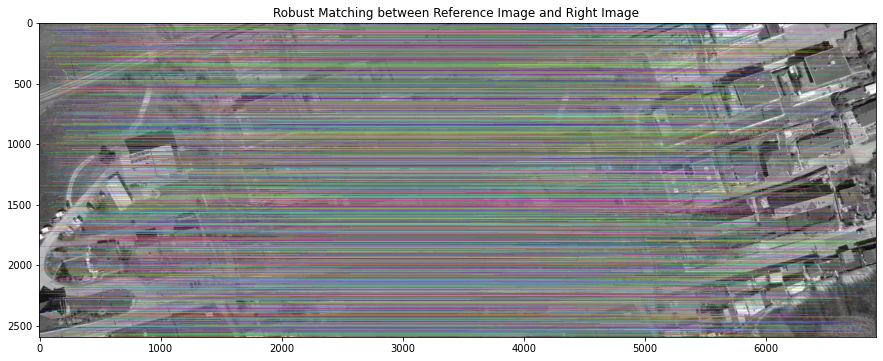

11847


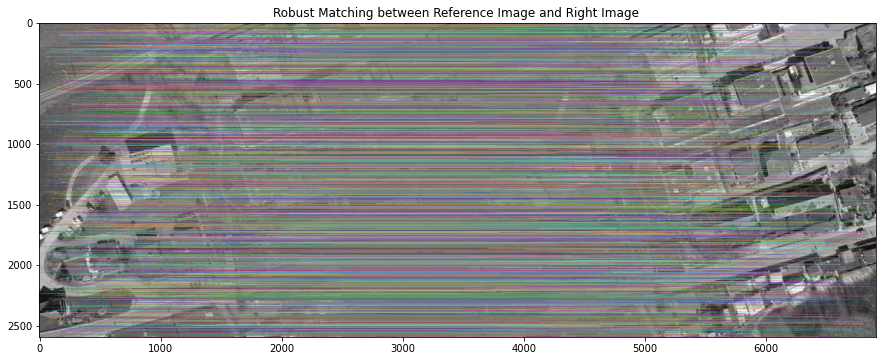

11847


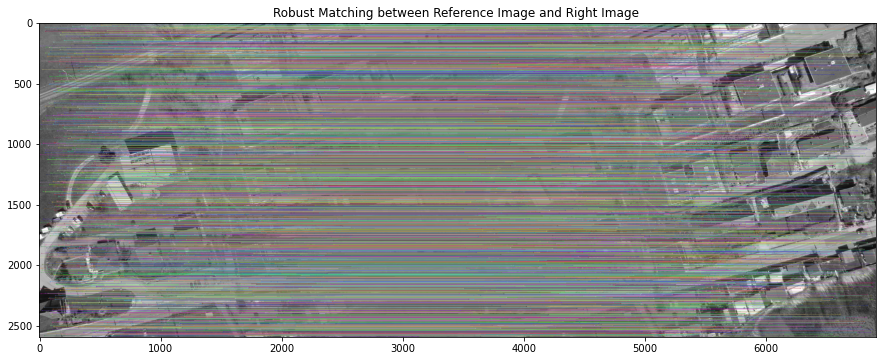

11847


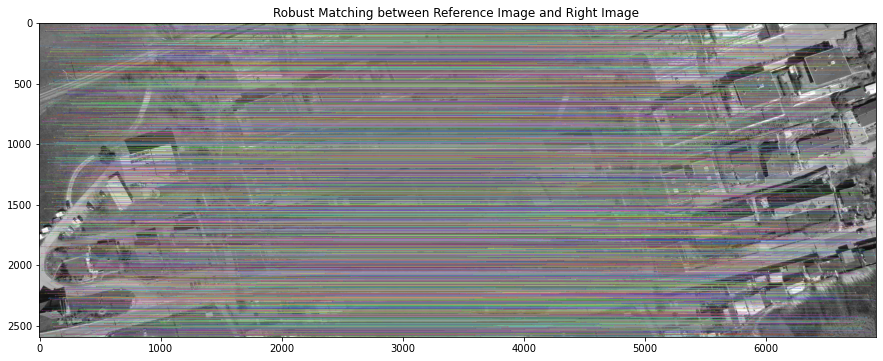

time: 1min 57s (started: 2021-06-01 15:33:33 +00:00)


In [195]:
H_left = []
H_right = []
poor_match_index_left = []
poor_match_index_right = []

for j in tqdm(range(len(images_left))):
  #print(j)
  if j==len(images_left)-1:
    break

  H_a = get_Hmatrix(images_left[j:j+2][::-1],keypoints_all_left[j:j+2][::-1],points_all_left[j:j+2][::-1],descriptors_all_left[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_left.append(j+1)
  #  continue

  H_left.append(H_a)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a = get_Hmatrix(images_right[j:j+2][::-1],keypoints_all_right[j:j+2][::-1],points_all_right[j:j+2][::-1],descriptors_all_right[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_right.append(j+1)
  #  continue


  H_right.append(H_a)


In [106]:
print(len(H_left),len(H_right))

5 5
time: 1.56 ms (started: 2021-06-01 13:03:03 +00:00)


In [ ]:
print(poor_match_index_left)
print(poor_match_index_right)

[1]
[]
time: 2.82 ms (started: 2021-05-31 08:48:17 +00:00)


In [ ]:
plt.imshow(images_left[poor_match_index_left[0]])

In [ ]:
poor_match_index_right, poor_match_index_left=[],[]

time: 1.15 ms (started: 2021-05-31 07:04:08 +00:00)


In [107]:
def warpnImages(images_left, images_right,H_left,H_right,poor_match_index_left,poor_match_index_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')

    warp_imgs_left = []
    warp_imgs_right = []


    for j,H in enumerate(H_left):
      #print(j)
      #if j ==2:
        #result = cv2.warpPerspective(images_left[j+2], H_trans, (xmax-xmin, ymax-ymin))
        #warp_imgs_left.append(result)
      #  continue
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H


      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      #plt.imshow(result)
      #plt.show()


      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)
    


    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H

      if j in poor_match_index_right:
        result = cv2.warpPerspective(images_right[j+2], H_trans, (xmax-xmin, ymax-ymin))
        warp_imgs_right.append(result)
        continue

      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step3:Done')

    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]

    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      #if j==1:
      #  continue
      
      warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      warp_img_init = warp_final
      #print(j)
      
      #plt.imshow(warp_final)
      #plt.show()

      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_final








  

time: 143 ms (started: 2021-06-01 13:03:12 +00:00)


In [ ]:
combined_warp_n = warpnImages(images_left, images_right,H_left,H_right,poor_match_index_left,poor_match_index_right)

## **Observation**

Need to fix a bug in the code (Like Maybe needing to normalize the Keypoints from the SuperPoint model)
## **To Do Tasks:**



*   Clear the bug
*   Stitch







## **References**

https://github.com/rpautrat/SuperPoint

https://arxiv.org/pdf/1712.07629.pdf

